## Demo target data generator

This notebook shows how to use the target data generator to supply training data to use when fitting the PDF model. The `target_data_generator` implemented in `fit_target_data_model.py` yields an infinite stream of target data, by randomly generating new arrays of $p_{50\%}$ and $\log_{10}M_{\rm p},$ and computing the mean and variance of the input concentrations across time.

In [1]:
%matplotlib inline

In [2]:
import matplotlib.cm as cm
from time import time
from matplotlib import lines as mlines

### Load the simulation data that includes best-fitting diffprof parameters

In [3]:
import os
from astropy.table import Table
diffprof_drn = "/Users/aphearin/work/DATA/diffprof_data"
mdpl2 = Table.read(os.path.join(diffprof_drn, "MDPL2_halo_table.hdf5"))
bpl = Table.read(os.path.join(diffprof_drn, "BPL_halo_table.hdf5"))
print(bpl.keys())

['halo_id', 'conc_beta_early', 'conc_beta_late', 'conc_k', 'conc_lgtc', 'u_conc_beta_early', 'u_conc_beta_late', 'u_conc_k', 'u_conc_lgtc', 'logmp', 'mah_early', 'mah_late', 'mah_logtc', 'mah_k', 'log_mah_fit', 'conch_fit', 'tform_50', 'p_tform_50']


### Calculate ${\rm conc}(t_{\rm fit})$ based on the diffprof parameters

In [4]:
from diffprof.nfw_evolution import lgc_vs_lgt

lgc_vs_lgt_vmap = jjit(jvmap(lgc_vs_lgt, in_axes=(None, 0, 0, 0, 0)))

N_T = 25
TARR_FIT = np.linspace(2, 13.8, N_T)

lgconc_history_bpl = np.array(lgc_vs_lgt_vmap(
    np.log10(TARR_FIT), bpl["conc_lgtc"], bpl["conc_k"], bpl["conc_beta_early"], bpl["conc_beta_late"]))
lgconc_history_mdpl2 = np.array(lgc_vs_lgt_vmap(
    np.log10(TARR_FIT), mdpl2["conc_lgtc"], mdpl2["conc_k"], mdpl2["conc_beta_early"], mdpl2["conc_beta_late"]))


### Calculate downsampling masks

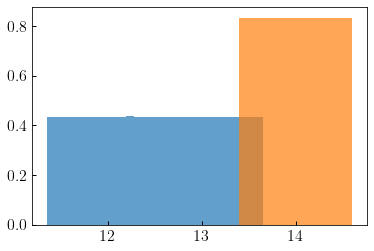

In [5]:
from diffprof.latin_hypercube_sampler import get_scipy_kdtree, retrieve_lh_sample_indices
tree_bpl = get_scipy_kdtree(bpl['logmp'])
tree_mdpl2 = get_scipy_kdtree(mdpl2['logmp'])

indx_bpl = retrieve_lh_sample_indices(tree_bpl, 11.35, 13.65, 1, 100_000)
indx_mdpl2 = retrieve_lh_sample_indices(tree_mdpl2, 13.4, 14.6, 1, 100_000)

fig, ax = plt.subplots(1, 1)
__=ax.hist(bpl['logmp'][indx_bpl], bins=30, density=True, alpha=0.7)
__=ax.hist(mdpl2['logmp'][indx_mdpl2], bins=30, density=True, alpha=0.7)


### Calculate the target data generator for this downsample of halos



In [6]:
from diffprof.get_target_simdata import target_data_generator

N_MH_TARGETS, N_P_TARGETS = 20, 15

args = (bpl['logmp'][indx_bpl],
    mdpl2['logmp'][indx_mdpl2],
    lgconc_history_bpl[indx_bpl],
    lgconc_history_mdpl2[indx_mdpl2],
    bpl['p_tform_50'][indx_bpl],
    mdpl2['p_tform_50'][indx_mdpl2],
    N_MH_TARGETS,
    N_P_TARGETS
       )
gen = target_data_generator(*args)

### Plot average concentration vs. mass

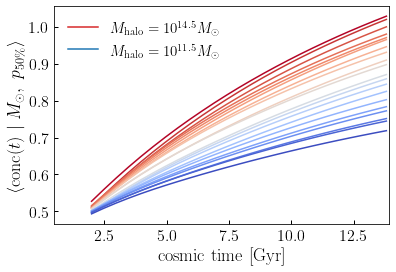

In [7]:
target_data = next(gen)
lgmhalo_targets, p50_targets = target_data[0:2]
lgc_mean_targets_lgm0, lgc_std_targets_lgm0 = target_data[2:4]
lgc_mean_targets_lgm0_p50, lgc_std_targets_lgm0_p50 = target_data[4:]

lgm_colors=cm.coolwarm(np.linspace(1,0,N_MH_TARGETS))
fig, ax = plt.subplots(1, 1)
xlim = ax.set_xlim(0.5, 13.9)
xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
ylabel = ax.set_ylabel(r'$\langle{\rm conc}(t)\ \vert\ M_{\odot},\ p_{50\%}\rangle$')
for im in range(N_MH_TARGETS):
    __=ax.plot(TARR_FIT, lgc_mean_targets_lgm0[im, :], color=lgm_colors[im])

    
red_line=mlines.Line2D([],[],ls='-',c=mred,label=r'$M_{\rm halo}=10^{14.5}M_{\odot}$')
blue_line=mlines.Line2D([],[],ls='-',c=mblue,label=r'$M_{\rm halo}=10^{11.5}M_{\odot}$')
leg=ax.legend(handles=[red_line, blue_line])

fig.savefig('mean_lgm0_targets.png', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight', dpi=200)

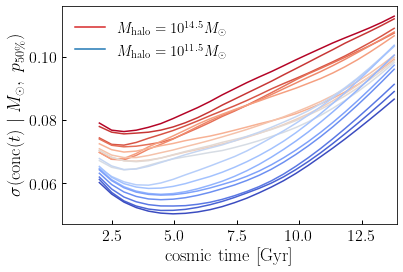

In [8]:
lgm_colors=cm.coolwarm(np.linspace(1,0,N_MH_TARGETS))
fig, ax = plt.subplots(1, 1)
xlim = ax.set_xlim(0.5, 13.9)
xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
ylabel = ax.set_ylabel(r'$\sigma({\rm conc}(t)\ \vert\ M_{\odot},\ p_{50\%})$')

for im in range(N_MH_TARGETS):
    __=ax.plot(TARR_FIT, lgc_std_targets_lgm0[im, :], color=lgm_colors[im])
red_line=mlines.Line2D([],[],ls='-',c=mred,label=r'$M_{\rm halo}=10^{14.5}M_{\odot}$')
blue_line=mlines.Line2D([],[],ls='-',c=mblue,label=r'$M_{\rm halo}=10^{11.5}M_{\odot}$')
leg=ax.legend(handles=[red_line, blue_line])
fig.savefig('std_lgm0_targets.png', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight', dpi=200)

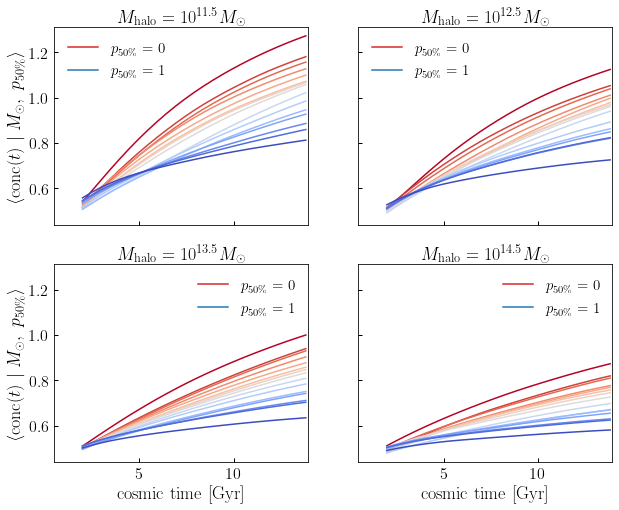

In [9]:
p50_colors=cm.coolwarm(np.linspace(1, 0, N_P_TARGETS))

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 8))
# fig.subplots_adjust(wspace=0, hspace=0)
xlim = ax0.set_xlim(0.5, 13.9)
axes = ax0, ax1, ax2, ax3

for ax in ax2, ax3:
    xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
    

for ax in ax0, ax2:
    ylabel = ax.set_ylabel(r'$\langle{\rm conc}(t)\ \vert\ M_{\odot},\ p_{50\%}\rangle$')
        

red_line=mlines.Line2D([],[],ls='-',c=mred,label=r'$p_{50\%}=0$')
blue_line=mlines.Line2D([],[],ls='-',c=mblue,label=r'$p_{50\%}=1$')
for ax, lgm in zip(axes, (11.5, 12.5, 13.5, 14.5)):
    im = np.argmin(np.abs(lgmhalo_targets - lgm))
    for ip, p50 in enumerate(p50_targets):
        __=ax.plot(TARR_FIT, lgc_mean_targets_lgm0_p50[im, ip, :], color=p50_colors[ip])
    leg=ax.legend(handles=[red_line, blue_line])

titles = (r'$M_{\rm halo}=10^{11.5}M_{\odot}$',r'$M_{\rm halo}=10^{12.5}M_{\odot}$',
       r'$M_{\rm halo}=10^{13.5}M_{\odot}$', r'$M_{\rm halo}=10^{14.5}M_{\odot}$')
for ax, title in zip(axes, titles):
    __=ax.set_title(title)
fig.savefig('mean_p50_targets.png', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight', dpi=200)

Runtime to generate target data = 5.3 seconds


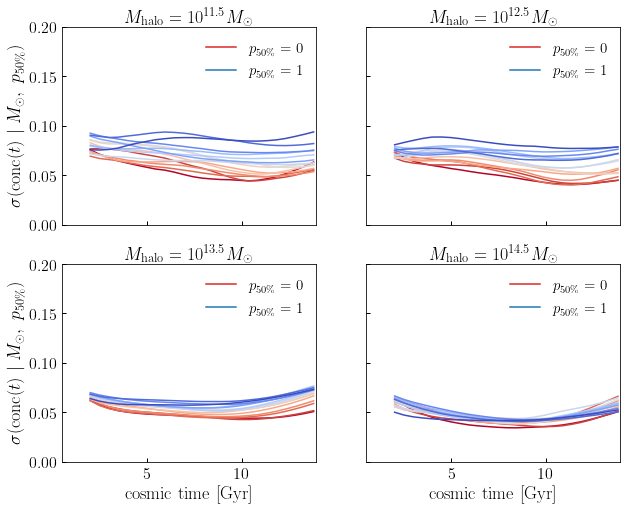

In [10]:
start = time()
target_data = next(gen)
lgmhalo_targets, p50_targets = target_data[0:2]
lgc_mean_targets_lgm0, lgc_std_targets_lgm0 = target_data[2:4]
lgc_mean_targets_lgm0_p50, lgc_std_targets_lgm0_p50 = target_data[4:]
end = time()
print("Runtime to generate target data = {0:.1f} seconds".format(end-start))

p50_colors=cm.coolwarm(np.linspace(1, 0, N_P_TARGETS))

fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 8))
xlim = ax0.set_xlim(0.5, 13.9)
ylim = ax0.set_ylim(0, 0.2)
axes = ax0, ax1, ax2, ax3

red_line=mlines.Line2D([],[],ls='-',c=mred,label=r'$p_{50\%}=0$')
blue_line=mlines.Line2D([],[],ls='-',c=mblue,label=r'$p_{50\%}=1$')

for ax, lgm in zip(axes, (11.5, 12.5, 13.5, 14.5)):
    im = np.argmin(np.abs(lgmhalo_targets - lgm))
    for ip, p50 in enumerate(p50_targets):
        __=ax.plot(TARR_FIT, lgc_std_targets_lgm0_p50[im, ip, :], color=p50_colors[ip])
    leg=ax.legend(handles=[red_line, blue_line])

for ax in ax2, ax3:
    xlabel = ax.set_xlabel(r'${\rm cosmic\ time\ [Gyr]}$')
for ax in ax0, ax2:
    ylabel = ax.set_ylabel(r'$\sigma({\rm conc}(t)\ \vert\ M_{\odot},\ p_{50\%})$')

titles = (r'$M_{\rm halo}=10^{11.5}M_{\odot}$',r'$M_{\rm halo}=10^{12.5}M_{\odot}$',
       r'$M_{\rm halo}=10^{13.5}M_{\odot}$', r'$M_{\rm halo}=10^{14.5}M_{\odot}$')
for ax, title in zip(axes, titles):
    __=ax.set_title(title)
fig.savefig('std_p50_targets.png', bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight', dpi=200)